## Some Standard imports

In [ ]:
!pip install --upgrade scikit-learn catboost xgboost pycaret

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 69.2 MB 11 kB/s 
     |████████████████████████████████| 166.7 MB 16 kB/s 
     |████████████████████████████████| 263 kB 54.0 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 105 kB 51.4 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 6.8 MB 30.1 MB/s 
     |████████████████████████████████| 248 kB 57.2 MB/s 
     |████████████████████████████████| 271 kB 42.5 MB/s 
     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 1.7 MB 30.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 26.8 MB/s 
     |████████████████████████████████| 14.4 MB 28.7 MB/s 
     |█████████████████

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in the NEISS file: 

Description: contains injury data for individuals afflicted with basketball related injuries from 2011-2019. We are only interested in the following columns: 

* Age (numerical)
* Sex (categorical)
* Race (categorical)
* Body_Part (categorical): Coded numbers that correspond to body parts
* Diagnosis (categorical): Coded numbers that correspond to diagnostic codes
* Fire_Involvement (categorical): Whether or not a fire was involved with the incident 
* Stratum (categorical): The size of the hospital where the individual was seen
* Location (categorical): The location at which the injury took place 
 
What we want to predict is "Disposition" which is basically whether they were admitted or not

In [ ]:
# read in the file. Note that the columns are separated by tabs so we use the
# special character \t to indicate that
df = pd.read_csv('NEISS.TXT', delimiter='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# get the columns we want
df_smaller = df[['Age', 'Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 
                 'Fire_Involvement', 'Stratum', 'Location']]

# display the table so we can be sure it is what we want
display(df_smaller)

,Age,Sex,Race,Body_Part,Diagnosis,Disposition,Fire_Involvement,Stratum,Location
0,15,1,2,79,64,1,0,S,8
1,46,1,0,88,59,1,0,V,9
2,14,1,2,37,64,1,0,S,8
3,14,1,1,35,64,1,0,L,9
4,14,1,1,76,53,1,0,L,9
...,...,...,...,...,...,...,...,...,...
117105,13,1,2,37,64,1,0,C,0
117106,16,1,1,37,71,1,0,C,0
117107,14,1,2,37,57,1,0,C,0
117108,17,1,2,75,52,1,0,C,8


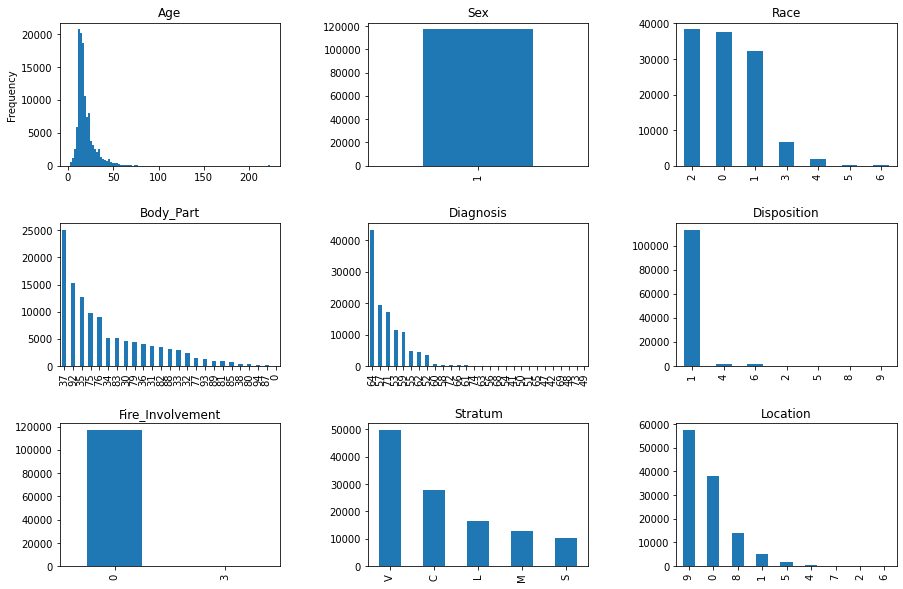

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, d in enumerate(df_smaller.columns):
  fig.add_subplot(3,3,idx+1)
  if d == 'Age':
    df[d].plot(kind='hist', bins=100, title=d)
  else:
    df[d].value_counts().plot(kind='bar', title=d)

In [ ]:
# remove any unknown values by setting their value to NaN (not a number) and dropping them
df_smaller.loc[df_smaller.Disposition == 9, 'Disposition'] = np.nan
df_smaller['Disposition'] = df_smaller['Disposition'].dropna()

# recode individuals admitted as "admit" and those not admitted as "notadmit"
df_smaller.loc[~df_smaller.Disposition.isin([4,5,8]), 'Disposition'] = 'notadmit'
df_smaller.loc[df_smaller.Disposition.isin([4,5,8]), 'Disposition'] = 'admit'
df_smaller['Disposition'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


notadmit    115065
admit         2045
Name: Disposition, dtype: int64

In [ ]:
# set the categorical data columns
categorical_cols = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Fire_Involvement', 'Stratum', 'Location'] 
# make dummy variables for them
df_dummy = pd.get_dummies(df_smaller, columns = categorical_cols)

# and display at the end. Should have 117110 rows and 79 columns
display(df_dummy) 

,Age,Disposition,Sex_1,Race_0,Race_1,Race_2,Race_3,Race_4,Race_5,Race_6,Body_Part_0,Body_Part_30,Body_Part_31,Body_Part_32,Body_Part_33,Body_Part_34,Body_Part_35,Body_Part_36,Body_Part_37,Body_Part_38,Body_Part_75,Body_Part_76,Body_Part_77,Body_Part_79,Body_Part_80,Body_Part_81,Body_Part_82,Body_Part_83,Body_Part_85,Body_Part_87,Body_Part_88,Body_Part_89,Body_Part_92,Body_Part_93,Body_Part_94,Diagnosis_41,Diagnosis_42,Diagnosis_47,Diagnosis_48,Diagnosis_49,Diagnosis_50,Diagnosis_51,Diagnosis_52,Diagnosis_53,Diagnosis_54,Diagnosis_55,Diagnosis_56,Diagnosis_57,Diagnosis_58,Diagnosis_59,Diagnosis_60,Diagnosis_61,Diagnosis_62,Diagnosis_63,Diagnosis_64,Diagnosis_65,Diagnosis_66,Diagnosis_68,Diagnosis_69,Diagnosis_71,Diagnosis_72,Diagnosis_73,Diagnosis_74,Fire_Involvement_0,Fire_Involvement_3,Stratum_C,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Location_0,Location_1,Location_2,Location_4,Location_5,Location_6,Location_7,Location_8,Location_9
0,15,notadmit,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,46,notadmit,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,14,notadmit,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,14,notadmit,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,14,notadmit,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117105,13,notadmit,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
117106,16,notadmit,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
117107,14,notadmit,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
117108,17,notadmit,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# set our "X" variable to be the predictors and set Y to be the outcome
X = df_dummy.loc[:, df_dummy.columns != 'Disposition']
Y = df_dummy['Disposition']

Install "imblearn" package to handle class imbalances

In [ ]:
!pip install imblearn

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

It looks like we have a class imbalance since our 'admit' cases are less than 1% of our data. We should attempt to resample our training dataset.

In [ ]:

X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_imbalanced, y_train_imbalanced)

print(Counter(y_train))
print(Counter(y_test))

Counter({'notadmit': 80548, 'admit': 80548})
Counter({'notadmit': 34517, 'admit': 616})


In [ ]:
from sklearn import tree

scoring = ['accuracy', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'roc_auc']
clf = tree.DecisionTreeClassifier(random_state=42)
scores = cross_validate(clf, X_train, y_train, scoring=scoring, return_estimator=True)
clf = scores['estimator'][np.argmax(scores['test_recall_macro'])]

In [ ]:
for k in scores.keys():
  if k != 'estimator':
    print(f"Train {k}: {np.mean(scores[k])}")


Train fit_time: 1.4731069564819337
Train score_time: 1.023167085647583
Train test_accuracy: 0.9784415259094779
Train test_balanced_accuracy: 0.9784415399606011
Train test_precision_macro: 0.9789091347863037
Train test_recall_macro: 0.9784415399606011
Train test_roc_auc: 0.9875067423689551


### Alternatively you can grid search

In [ ]:
tree_para = {'criterion':['gini','entropy'],
             'max_depth': [1,2,4]}

clf = GridSearchCV(tree.DecisionTreeClassifier(), tree_para, cv=5, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.0s finished


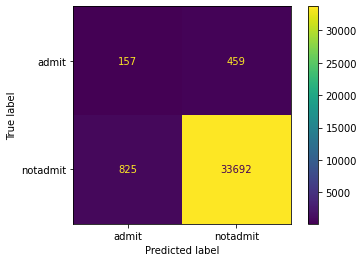

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, values_format = '')

              precision    recall  f1-score   support

       admit       0.14      0.30      0.19       616
    notadmit       0.99      0.97      0.98     34517

    accuracy                           0.95     35133
   macro avg       0.56      0.63      0.58     35133
weighted avg       0.97      0.95      0.96     35133



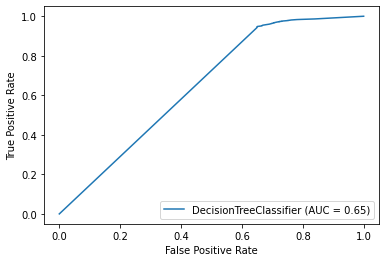

In [ ]:
from sklearn.metrics import classification_report, plot_roc_curve

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

plot_roc_curve(clf, X_test, y_test)

Only run this cell if the above number is < 100

In [ ]:
import graphviz
if (clf.tree_.node_count < 100):
  dot_data = tree.export_graphviz(clf, out_file=None, 
                                  feature_names=X.columns,
                                  class_names=['admit','notadmit']) 
  graph = graphviz.Source(dot_data) 
  graph.render("neiss")

# Approach \# 2: PyCaret

In [ ]:
df_smaller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117110 entries, 0 to 117109
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Age               117110 non-null  int64 
 1   Sex               117110 non-null  int64 
 2   Race              117110 non-null  int64 
 3   Body_Part         117110 non-null  int64 
 4   Diagnosis         117110 non-null  int64 
 5   Disposition       117110 non-null  object
 6   Fire_Involvement  117110 non-null  int64 
 7   Stratum           117110 non-null  object
 8   Location          117110 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 8.0+ MB


In [ ]:
from pycaret.classification import *

df_smaller['Body_Part'] = df_smaller['Body_Part'].astype('category')
df_smaller['Diagnosis'] = df_smaller['Diagnosis'].astype('category')
df_smaller['Sex'] = df_smaller['Sex'].astype('category')
df_smaller['Race'] = df_smaller['Race'].astype('category')
df_smaller['Fire_Involvement'] = df_smaller['Fire_Involvement'].astype('category')
df_smaller['Stratum'] = df_smaller['Stratum'].astype('category')
df_smaller['Location'] = df_smaller['Location'].astype('category')

df_smaller.loc[df_smaller.Disposition == 'admit', 'Disposition'] = 1
df_smaller.loc[df_smaller.Disposition == 'notadmit', 'Disposition'] = 0

print(Counter(df_smaller['Disposition']))

Counter({0: 115065, 1: 2045})


In [23]:
grid=setup(data=df_smaller, target='Disposition', verbose=True, fix_imbalance=True, 
           bin_numeric_features=['Age'], log_experiment=True, 
           experiment_name='adv1', fold=5)

,Description,Value
0,session_id,3088
1,Target,Disposition
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(117110, 9)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
topmodels = compare_models(n_select = len(models()))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9634,0.8698,0.2853,0.1696,0.2126,0.1951,0.2021,93.706
et,Extra Trees Classifier,0.9625,0.7303,0.2565,0.1525,0.1911,0.1732,0.1794,30.150
rf,Random Forest Classifier,0.9623,0.7874,0.2480,0.1482,0.1854,0.1673,0.1732,20.728
xgboost,Extreme Gradient Boosting,0.9611,0.8716,0.3211,0.1704,0.2226,0.2045,0.2155,50.554
dt,Decision Tree Classifier,0.9602,0.6710,0.2733,0.1484,0.1923,0.1738,0.1824,2.412
lightgbm,Light Gradient Boosting Machine,0.9558,0.8785,0.3802,0.1649,0.2299,0.2108,0.2306,3.500
knn,K Neighbors Classifier,0.8926,0.7214,0.3999,0.0668,0.1145,0.0873,0.1289,341.036
gbc,Gradient Boosting Classifier,0.8632,0.8760,0.6901,0.0835,0.1490,0.1218,0.2072,29.984
ada,Ada Boost Classifier,0.8449,0.8708,0.7175,0.0767,0.1385,0.1106,0.1999,7.728
lr,Logistic Regression,0.7978,0.8762,0.8067,0.0658,0.1217,0.0925,0.1929,10.828


#### Note: this will be different from the book since a subsequent run of this algorithm returned better results.

In [28]:
xgboost = topmodels[3]
lgbm = topmodels[5]
gbm = topmodels[7]
ada = topmodels[8]
lr = topmodels[9]
lda = topmodels[11]

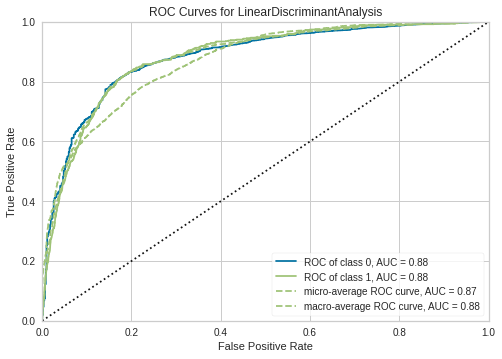

In [31]:
plot_model(lda, 'auc')

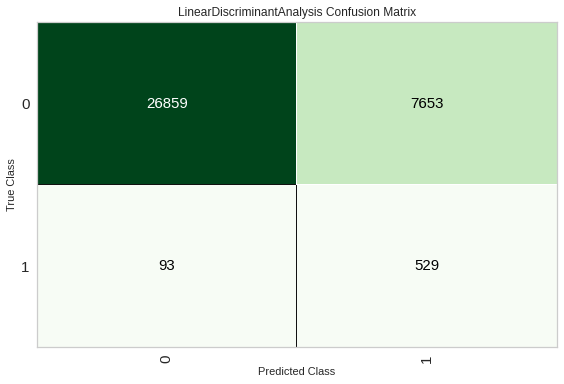

In [32]:
plot_model(lda, 'confusion_matrix')

In [36]:
blender = blend_models(estimator_list=[xgboost, lgbm, gbm, ada, lr, lda], method='auto', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8955,0.8700,0.6281,0.1002,0.1729,0.1473,0.2216
1,0.9002,0.8942,0.6303,0.1046,0.1794,0.1543,0.2284
2,0.9053,0.8739,0.6021,0.1061,0.1805,0.1556,0.2247
3,0.9058,0.8947,0.6421,0.1125,0.1915,0.1669,0.2416
4,0.9105,0.8779,0.5614,0.1065,0.1790,0.1543,0.2165
Mean,0.9034,0.8822,0.6128,0.1060,0.1807,0.1557,0.2266
SD,0.0051,0.0103,0.0288,0.0040,0.0061,0.0063,0.0085


In [40]:
predict_model(blender, probability_threshold=0.4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8325,0.8894,0.8103,0.0804,0.1462,0.1178,0.2215


,Sex_1,Race_0,Race_1,Race_2,Race_3,Race_4,Race_5,Race_6,Body_Part_0,Body_Part_30,Body_Part_31,Body_Part_32,Body_Part_33,Body_Part_34,Body_Part_35,Body_Part_36,Body_Part_37,Body_Part_38,Body_Part_75,Body_Part_76,Body_Part_77,Body_Part_79,Body_Part_80,Body_Part_81,Body_Part_82,Body_Part_83,Body_Part_85,Body_Part_87,Body_Part_88,Body_Part_89,Body_Part_92,Body_Part_93,Body_Part_94,Diagnosis_41,Diagnosis_42,Diagnosis_47,Diagnosis_49,Diagnosis_50,Diagnosis_51,Diagnosis_52,...,Diagnosis_69,Diagnosis_71,Diagnosis_72,Diagnosis_74,Fire_Involvement_3,Stratum_C,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Location_0,Location_1,Location_2,Location_4,Location_5,Location_6,Location_7,Location_8,Location_9,Age_0.0,Age_1.0,Age_10.0,Age_11.0,Age_12.0,Age_13.0,Age_14.0,Age_15.0,Age_16.0,Age_17.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,Disposition,Label,Score
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8062
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8879
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.7600
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8486
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35129,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.4023
35130,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8125
35131,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8864
35132,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0